In [10]:
# !pip install opencv-python
# !pip install numpy
# !pip install Pillow
# !pip install matplotlib
# !pip install scikit-image
# !pip install scikit-learn

import argparse
import cv2
import numpy as np
import os
import random
from merge_image import merge_patches
import numpy as np
from PIL import Image
from cut_image import make_patches
from IPython.display import display
import matplotlib.pyplot as plt
from option import parse_opt
import copy
opt = parse_opt()

def test(input_image=opt.image_path,row=opt.row_num, col=opt.col_num):
    ### Original image
    opt.row_num = row
    opt.col_num = col
    opt.image_path = input_image
    
    rgb_image = cv2.cvtColor(cv2.imread(opt.image_path), cv2.COLOR_BGR2RGB)
    print(f'original image shape : {rgb_image.shape}')
    plt.subplot(121)
    plt.imshow(rgb_image)
    plt.text(0.5, -0.1, 'before', transform=plt.gca().transAxes, ha='center')
    plt.axis('off')

    ### cut_images
    patches = make_patches(opt)

    ### merge
    
    image_patches = patches.processed_images
    # image_patches = [cv2.cvtColor(cv2.imread(f'{opt.output_filename}_{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(opt.row_num * opt.col_num)]

    merge_patches(opt, image_patches)
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(cv2.imread(f'{opt.result_filename}.jpg'), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.text(0.5, -0.1, 'after', transform=plt.gca().transAxes, ha='center')
    plt.show()

# Image1

original image shape : (162, 300, 3)


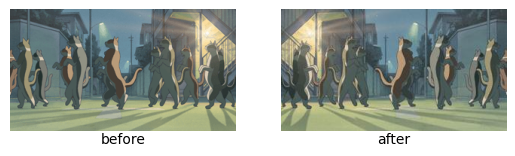

original image shape : (162, 300, 3)


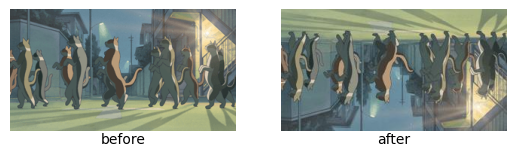

original image shape : (162, 300, 3)


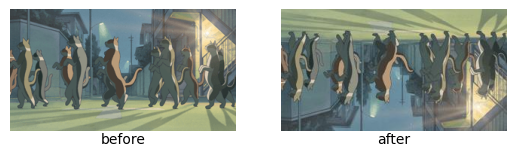

In [14]:
test('./image/image1.jpg',2,2)
test('./image/image1.jpg',3,3)
test('./image/image1.jpg',3,4)

# Image2

original image shape : (213, 319, 3)


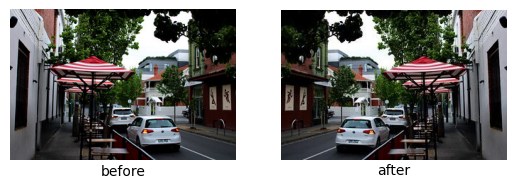

original image shape : (213, 319, 3)


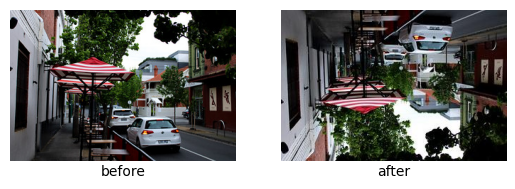

original image shape : (213, 319, 3)


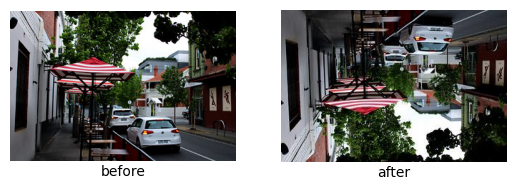

In [3]:
test('./image/image2.jpg',2,2)
test('./image/image2.jpg',3,3)
test('./image/image2.jpg',3,4)

# 실행 과정 확인

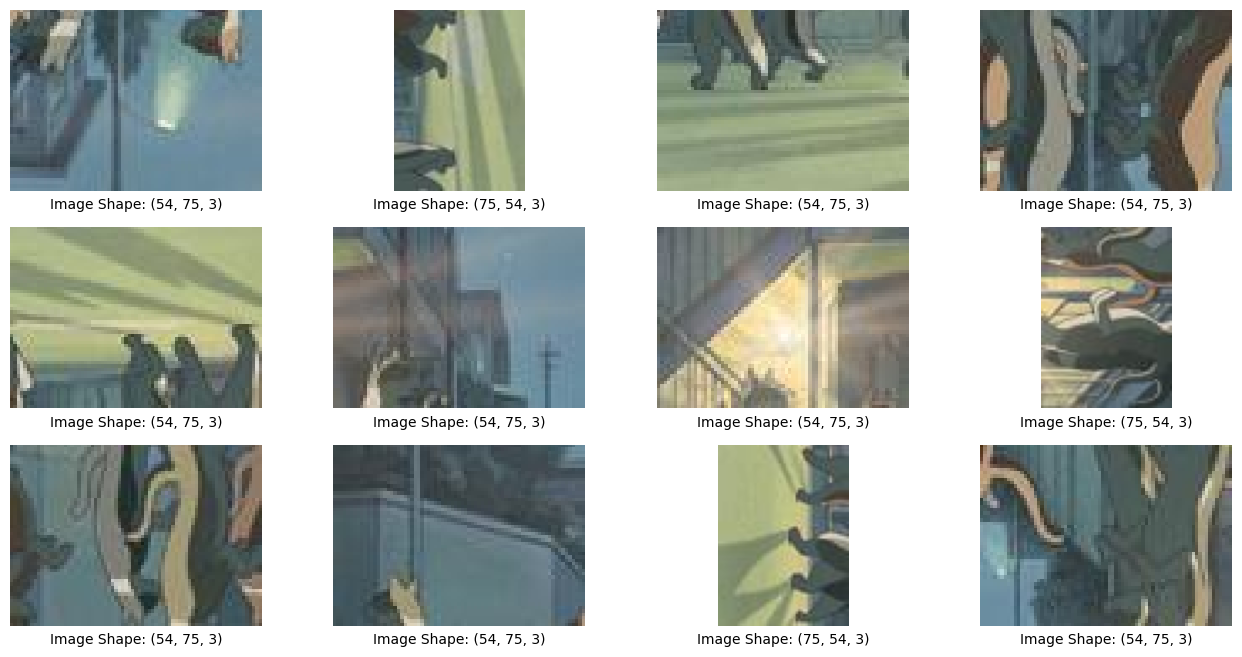

In [27]:
'''
cut_images한 결과 확인
'''

plt.figure(figsize=(16,8))
for i in range(opt.row_num * opt.col_num):
    image = cv2.cvtColor(cv2.imread(f'{opt.output_filename}_{i}.jpg'), cv2.COLOR_BGR2RGB)
    title = f'Image Shape: {image.shape}'
    plt.subplot(opt.row_num, opt.col_num, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.text(0.5, -0.1, title, transform=plt.gca().transAxes, ha='center')
plt.show()

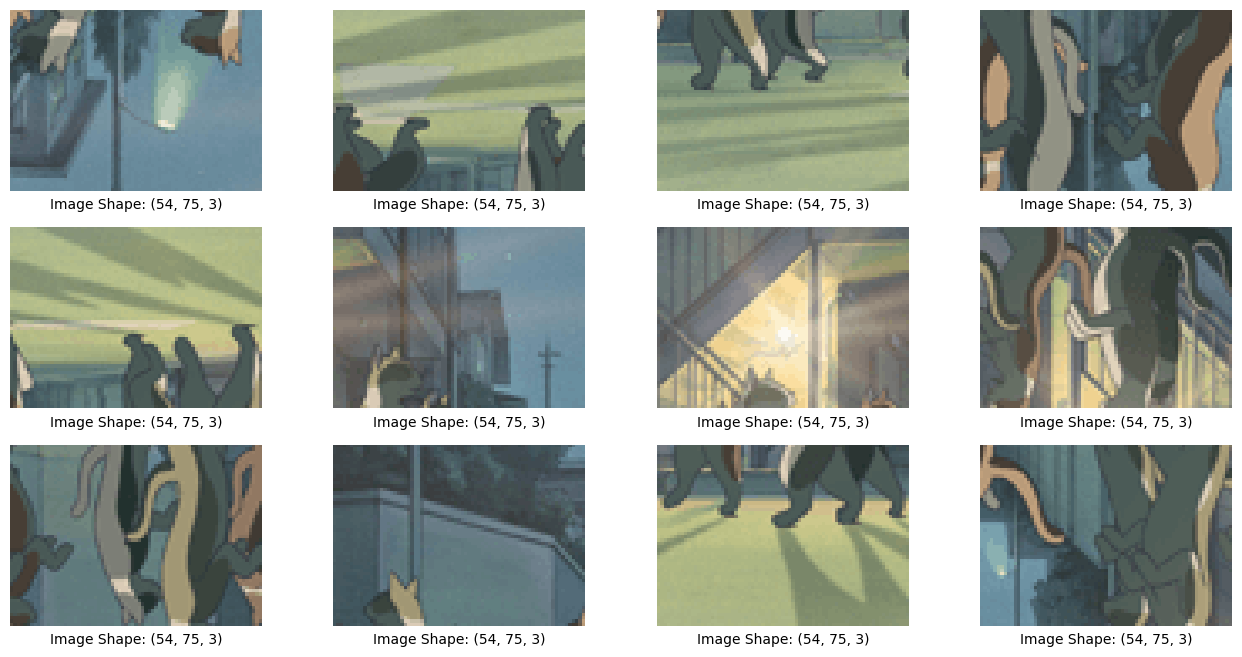

In [28]:
'''
image의 shape를 동일하게 맞추는 과정.
'''

def rotate_image(image):
    pil_image = Image.fromarray(image)
    rotated_image = pil_image.rotate(90, expand=True)
    rotated_image = np.array(rotated_image)
    return rotated_image

def process_image(image):
    if image.shape[1] < image.shape[0]:
        image = rotate_image(image)
    return image

# 이미지들을 담고 있는 image_patches 리스트

image_patches = make_patches(opt).processed_images
# image_patches = [cv2.cvtColor(cv2.imread(f'{opt.output_filename}_{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(opt.row_num * opt.col_num)]
image_patches = [process_image(image) for image in image_patches]  # 이미지들을 적절히 초기화

plt.figure(figsize=(16,8))
for i in range(opt.row_num * opt.col_num):
    title = f'Image Shape: {image_patches[i].shape}'
    plt.subplot(opt.row_num, opt.col_num, i+1)
    plt.imshow(image_patches[i])
    plt.axis('off')
    plt.text(0.5, -0.1, title, transform=plt.gca().transAxes, ha='center')
plt.show()


right 0.9947913752374209


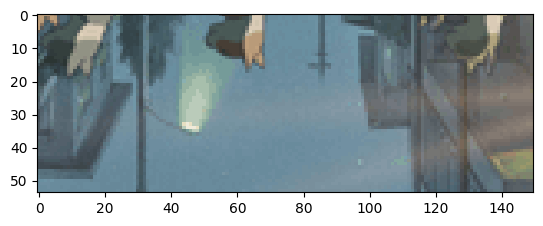

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f4535dcc0>,
 'image/png': None}

right 0.904833139904887


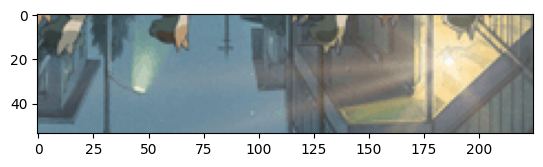

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f4499dde0>,
 'image/png': None}

left 0.8251964400196823


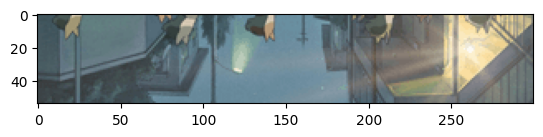

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f44b38850>,
 'image/png': None}

left 0.8785694736644168


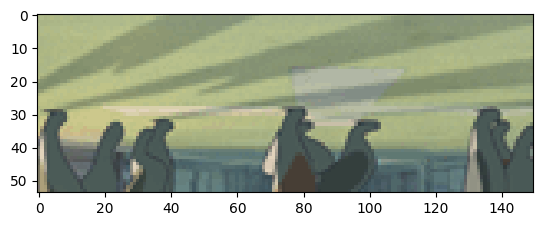

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f4499c280>,
 'image/png': None}

right 0.8697537809832284


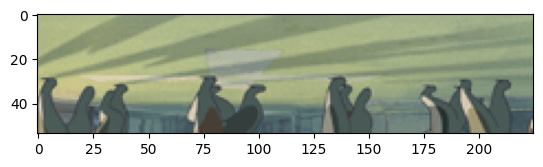

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f44825f90>,
 'image/png': None}

left 0.6881613622626107


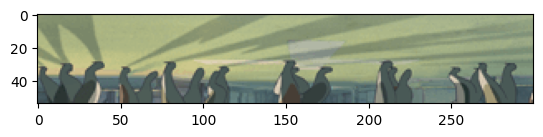

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f450c1150>,
 'image/png': None}

right 0.8701747846819468


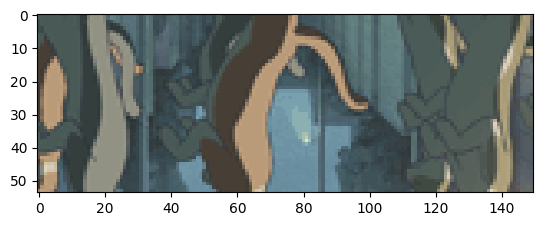

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f449432e0>,
 'image/png': None}

right 0.7525928492186024


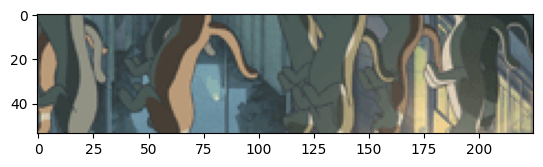

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f449c7fd0>,
 'image/png': None}

left 0.7525245025351726


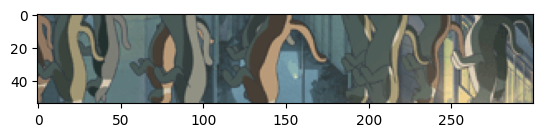

{'text/plain': <matplotlib.image.AxesImage at 0x7f1f447ba980>,
 'image/png': None}

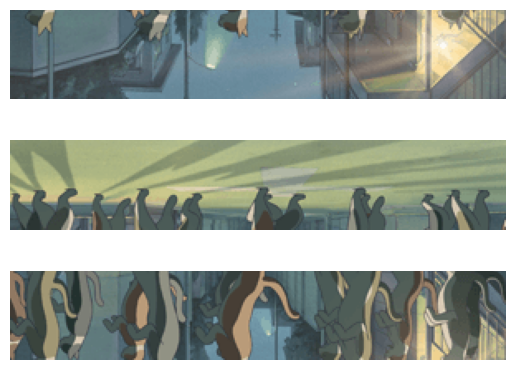

In [29]:
'''
이미지를 겹치는 과정을 확인
'''

from skimage.metrics import structural_similarity as ssim

def mirror(image):
        image = np.fliplr(image)
        return image

def flip(image):
    image = np.flipud(image)
    return image

def calculate_sim(image1, image2):
    # Normalize the images to the range [0, 1]
    
    image1 = image1.astype(np.float64) / 255.0
    image2 = image2.astype(np.float64) / 255.0
    
    # Calculate SSIM
    ssim_score1 = ssim(image1, image2, win_size=3,data_range=1, multichannel=True, gaussian_weightsbool=True)
    return ssim_score1

def col_combine(image_patches, row_num, col_num):

    combined_image = []

    for _ in range(row_num):
        root_image = image_patches.pop(0)

        for _ in range(col_num-1):
            best_sim = -1
            best_idx = -1
            best_patch = None
            way = None

            for idx, patche in enumerate(image_patches):
                
                left = root_image[:,0,:]
                right = root_image[:,-1,:]

                le = patche[:,0,:] #left_edge 
                lfe = flip(patche)[:,0,:] # left_flip_edge 
                re = patche[:,-1,:] # right_edge 
                rfe = flip(patche)[:,-1,:] # right_flip_edge 

                le_le = calculate_sim(left, le)
                le_lfe = calculate_sim(left, lfe)
                le_re = calculate_sim(left, re)
                le_rfe = calculate_sim(left, rfe)
                rg_le = calculate_sim(right, le)
                rg_lfe = calculate_sim(right, lfe)
                rg_re = calculate_sim(right, re)
                rg_rfe = calculate_sim(right, rfe)

                # 왼쪽에 붙이는 경우
                if best_sim < le_le:
                    best_sim = le_le
                    best_patch = mirror(patche)
                    best_idx = idx
                    way = 'left'
                if best_sim < le_lfe:
                    best_sim = le_lfe
                    best_patch = mirror(flip(patche))
                    best_idx = idx
                    way = 'left'
                if best_sim < le_re:
                    best_sim = le_re
                    best_patch = patche
                    best_idx = idx
                    way = 'left'
                if best_sim < le_rfe:
                    best_sim = le_rfe
                    best_patch = flip(patche)
                    best_idx = idx
                    way = 'left'

                # 오른쪽에 붙이는 경우
                if best_sim < rg_le:
                    best_sim = rg_le
                    best_patch = patche
                    best_idx = idx
                    way = 'right'
                if best_sim < rg_lfe:
                    best_sim = rg_lfe
                    best_patch = flip(patche)
                    best_idx = idx
                    way = 'right'
                if best_sim < rg_re:
                    best_sim = rg_re
                    best_patch = mirror(patche)
                    best_idx = idx
                    way = 'right'
                if best_sim < rg_rfe:
                    best_sim = rg_rfe
                    best_patch = mirror(flip(patche))
                    best_idx = idx
                    way = 'right'
                # print([le_le,le_lfe,le_re,le_rfe,rg_le,rg_lfe,rg_re,rg_rfe])
            image_patches.pop(best_idx)
            if way == 'left':
                root_image = np.concatenate((best_patch, root_image), axis=1)
            else:
                root_image = np.concatenate((root_image, best_patch), axis=1)

            print(way, best_sim)
            
            display({
                'text/plain': plt.imshow(root_image),
                'image/png': plt.show()
            })
            # display({
            #     'text/plain': plt.imshow(best_patch),
            #     'image/png': plt.show()
            # })

        combined_image.append(root_image)
    return combined_image

t = copy.deepcopy(image_patches)
a = col_combine(t, opt.row_num, opt.col_num)

for i in range(len(a)):
    plt.subplot(opt.row_num,1,i+1)
    plt.axis('off')
    plt.imshow(a[i])
plt.show()

## Error1

In [4]:
# cut_image.py의 processed_images를 Image.fromarray()와 save를 거쳐 imread, cvtColor(cv2.BGR2RGB)의 결과와
# 실제 processed_images의 데이터를 확인해보면 데이터가 아래와 같이 조금은 틀림.

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(54, 75, 3) (54, 75, 3)
False
[192 160 124] [189 163 136]


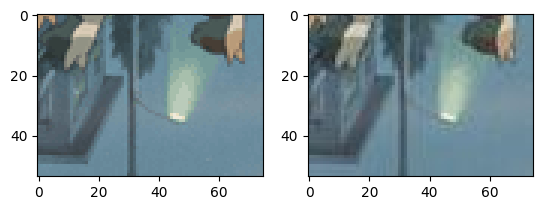

In [25]:
t0 = make_patches(opt).processed_images
t1 = t0[0]
t2 = cv2.cvtColor(cv2.imread(f'{opt.output_filename}_0.jpg'), cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(t1)
plt.subplot(122)
plt.imshow(t2)

print(type(t1), type(t2))
print(t1.shape, t2.shape)
print(np.min(t1 == t2))
print(t1[0][0], t2[0][0]) # 이미지의 데이터가 다른 것을 확인.